# Image Captioning with RNNs
Implementation of vanilla recurrent neural networks and use them to train a model that can generate novel captions for images.

In [1]:
# As usual, a bit of setup

import time, os, json
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# Microsoft COCO
Using [Microsoft COCO dataset](http://mscoco.org/) which has become the standard testbed for image captioning. The dataset consists of 80,000 training images and 40,000 validation images, each annotated with 5 captions written by workers on Amazon Mechanical Turk.

Extracted features from the fc7 layer of the VGG-16 network pretrained on ImageNet are stored in the files `train2014_vgg16_fc7.h5` and `val2014_vgg16_fc7.h5` respectively. To cut down on processing time and memory requirements, dimensionality is reduced from 4096 to 512; these features can be found in the files `train2014_vgg16_fc7_pca.h5` and `val2014_vgg16_fc7_pca.h5`.

The raw images take up a lot of space (nearly 20GB) so it's not included in download. However all images are taken from Flickr, and URLs of the training and validation images are stored in the files `train2014_urls.txt` and `val2014_urls.txt` respectively. This allows you to download images on the fly for visualization. Since images are downloaded on-the-fly, **you must be connected to the internet to view images**.

Dealing with strings is inefficient, so we will work with an encoded version of the captions. Each word is assigned an integer ID, allowing us to represent a caption by a sequence of integers. The mapping between integer IDs and words is in the file `coco2014_vocab.json`, and we can use the function `decode_captions` as done below.

There are a couple special tokens that we add to the vocabulary. We prepend a special `<START>` token and append an `<END>` token to the beginning and end of each caption respectively. Rare words are replaced with a special `<UNK>` token (for "unknown"). In addition, since we want to train with minibatches containing captions of different lengths, we pad short captions with a special `<NULL>` token after the `<END>` token and don't compute loss or gradient for `<NULL>` tokens.

You can load all of the MS-COCO data (captions, features, URLs, and vocabulary) using the `load_coco_data` function from the file `coco_utils.py`. Run the following cell to do so:

In [16]:
import h5py

def load_coco_data(base_dir='utils/datasets/coco_captioning',
                   max_train=None,
                   pca_features=True):
  data = {}
  caption_file = os.path.join(base_dir, 'coco2014_captions.h5')
  with h5py.File(caption_file, 'r') as f:
    for k, v in f.items():
      data[k] = np.asarray(v)

  if pca_features:
    train_feat_file = os.path.join(base_dir, 'train2014_vgg16_fc7_pca.h5')
  else:
    train_feat_file = os.path.join(base_dir, 'train2014_vgg16_fc7.h5')
  with h5py.File(train_feat_file, 'r') as f:
    data['train_features'] = np.asarray(f['features'])

  if pca_features:
    val_feat_file = os.path.join(base_dir, 'val2014_vgg16_fc7_pca.h5')
  else:
    val_feat_file = os.path.join(base_dir, 'val2014_vgg16_fc7.h5')
  with h5py.File(val_feat_file, 'r') as f:
    data['val_features'] = np.asarray(f['features'])

  dict_file = os.path.join(base_dir, 'coco2014_vocab.json')
  with open(dict_file, 'r') as f:
    dict_data = json.load(f)
    for k, v in dict_data.items():
      data[k] = v

  train_url_file = os.path.join(base_dir, 'train2014_urls.txt')
  with open(train_url_file, 'r') as f:
    train_urls = np.asarray([line.strip() for line in f])
  data['train_urls'] = train_urls

  val_url_file = os.path.join(base_dir, 'val2014_urls.txt')
  with open(val_url_file, 'r') as f:
    val_urls = np.asarray([line.strip() for line in f])
  data['val_urls'] = val_urls

  # Maybe subsample the training data
  if max_train is not None:
    num_train = data['train_captions'].shape[0]
    mask = np.random.randint(num_train, size=max_train)
    data['train_captions'] = data['train_captions'][mask]
    data['train_image_idxs'] = data['train_image_idxs'][mask]

  return data

In [17]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook, but feel
# free to experiment with the original features by changing the flag below.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary
for k, v in data.items():
  if type(v) == np.ndarray:
    print(k, type(v), v.shape, v.dtype)
  else:
    print(k, type(v), len(v))

val_urls <class 'numpy.ndarray'> (40504,) <U63
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_features <class 'numpy.ndarray'> (40504, 512) float32
train_features <class 'numpy.ndarray'> (82783, 512) float32
word_to_idx <class 'dict'> 1004
idx_to_word <class 'list'> 1004
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_captions <class 'numpy.ndarray'> (195954, 17) int32


## Look at the data


The `sample_coco_minibatch` function is to sample minibatches of data from the data structure returned from `load_coco_data`. Running the following to sample a small minibatch of training data and show the images and their captions. Running it multiple times and looking at the results helps you to get a sense of the dataset.

Note that we decode the captions using the `decode_captions` function and that we download the images on-the-fly using their Flickr URL, so **you must be connected to the internet to viw images**.

In [41]:
#this function is used by next function
import os, tempfile
import urllib.error
from scipy.misc import imread

def image_from_url(url):
  """
  Read an image from a URL. Returns a numpy array with the pixel data.
  We write the image to a temporary file then read it back. Kinda gross.
  """
  try:
    f = urllib.request.urlopen(url)
    _, fname = tempfile.mkstemp()
    with open(fname, 'wb') as ff:
      ff.write(f.read())
    img = imread(fname)
    #os.remove(fname)
    return img
  except urllib.error.URLError as e:
    print('URL Error: ', e.reason, url)
  except urllib.error.HTTPError as e:
    print('HTTP Error: ', e.code, url)


def sample_coco_minibatch(data, batch_size=100, split='train'):
  split_size = data['%s_captions' % split].shape[0]
  mask = np.random.choice(split_size, batch_size)
  captions = data['%s_captions' % split][mask]
  image_idxs = data['%s_image_idxs' % split][mask]
  image_features = data['%s_features' % split][image_idxs]
  urls = data['%s_urls' % split][image_idxs]
  return captions, image_features, urls

def decode_captions(captions, idx_to_word):
  singleton = False
  if captions.ndim == 1:
    singleton = True
    captions = captions[None]
  decoded = []
  N, T = captions.shape
  for i in range(N):
    words = []
    for t in range(T):
      word = idx_to_word[captions[i, t]]
      if word != '<NULL>':
        words.append(word)
      if word == '<END>':
        break
    decoded.append(' '.join(words))
  if singleton:
    decoded = decoded[0]
  return decoded


[  1   4  99 414  11  14   8   7 222   6   4  58   2   0   0   0   0]


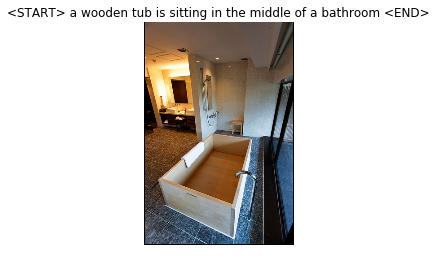

[  1   4 206  27   4 113 654 114 375  55  95   5   4 112   3   2   0]


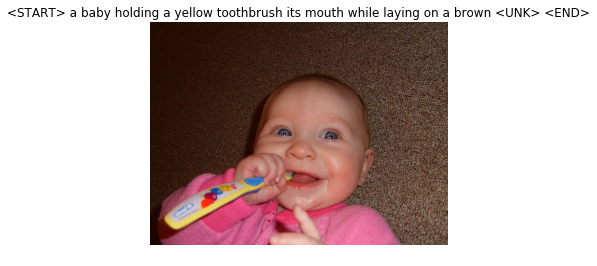

[  1   4  43   9  16 269 314  10   4 175   9   3   2   0   0   0   0]


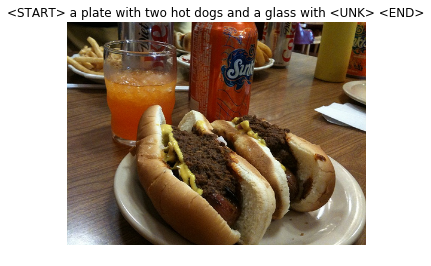

In [44]:
# Sample a minibatch and show the images and captions
batch_size = 3

captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
for i, (caption, url) in enumerate(zip(captions, urls)):
  plt.imshow(image_from_url(url))
  plt.axis('off')
  caption_str = decode_captions(caption, data['idx_to_word'])
  plt.title(caption_str)
  print(caption)
  plt.show()

# Recurrent Neural Networks
Recurrent neural network (RNN) language models for image captioning will be used. 

# Vanilla RNN: step forward

In [48]:
def rnn_step_forward(x, prev_h, Wx, Wh, b):
    """
    Run the forward pass for a single timestep of a vanilla RNN that uses a tanh
    activation function.
    The input data has dimension D, the hidden state has dimension H, and we use
    a minibatch size of N.
    Inputs:
    - x: Input data for this timestep, of shape (N, D).
    - prev_h: Hidden state from previous timestep, of shape (N, H)
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases of shape (H,)
    Returns a tuple of:
    - next_h: Next hidden state, of shape (N, H)
    - cache: Tuple of values needed for the backward pass.
    """
    next_h, cache = None, None
    # Step1: First get what inside the tanh
    forward = np.dot(x, Wx) + np.dot(prev_h, Wh) + b
    # Step2 : Squash anyhthing in there with tanh
    next_h = np.tanh(forward)

    # Add what's needed for the backaward pass
    cache = x, Wx, prev_h, Wh,  forward

    return next_h, cache

In [54]:
N, D, H = 3, 10, 4

x = np.linspace(-0.4, 0.7, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.2, 0.5, num=N*H).reshape(N, H)
Wx = np.linspace(-0.1, 0.9, num=D*H).reshape(D, H)
Wh = np.linspace(-0.3, 0.7, num=H*H).reshape(H, H)
b = np.linspace(-0.2, 0.4, num=H)

next_h, _ = rnn_step_forward(x, prev_h, Wx, Wh, b)
expected_next_h = np.asarray([
  [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
  [ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
  [ 0.97934501,  0.99144213,  0.99646691,  0.99854353]])

print('next_h error: ', rel_error(expected_next_h, next_h))

next_h error:  6.29242142647e-09


# Vanilla RNN: step backward


In [50]:
def rnn_step_backward(dnext_h, cache):
    """
    Backward pass for a single timestep of a vanilla RNN.
    Inputs:
    - dnext_h: Gradient of loss with respect to next hidden state
    - cache: Cache object from the forward pass
    Returns a tuple of:
    - dx: Gradients of input data, of shape (N, D)
    - dprev_h: Gradients of previous hidden state, of shape (N, H)
    - dWx: Gradients of input-to-hidden weights, of shape (N, H)
    - dWh: Gradients of hidden-to-hidden weights, of shape (H, H)
    - db: Gradients of bias vector, of shape (H,)
    """
    dx, dprev_h, dWx, dWh, db = None, None, None, None, None
    
    x, Wx, prev_h, Wh,  forward = cache

    # Backprop step 2:
    dforward = (1 - np.tanh(forward)**2) * dnext_h

    # Backprop step 1:
    dx = np.dot(dforward, Wx.T)
    dWx = np.dot(x.T, dforward)
    dprev_h = np.dot(dforward, Wh.T)
    dWh = np.dot(prev_h.T, dforward)
    db = np.sum(dforward, axis=0)

    return dx, dprev_h, dWx, dWh, db

In [55]:
def eval_numerical_gradient_array(f, x, df, h=1e-5):
  """
  Evaluate a numeric gradient for a function that accepts a numpy
  array and returns a numpy array.
  """
  grad = np.zeros_like(x)
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:
    ix = it.multi_index
    
    oldval = x[ix]
    x[ix] = oldval + h
    pos = f(x).copy()
    x[ix] = oldval - h
    neg = f(x).copy()
    x[ix] = oldval
    
    grad[ix] = np.sum((pos - neg) * df) / (2 * h)
    it.iternext()
  return grad


In [79]:
def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
  """ 
  a naive implementation of numerical gradient of f at x 
  - f should be a function that takes a single argument
  - x is the point (numpy array) to evaluate the gradient at
  """ 

  fx = f(x) # evaluate function value at original point
  grad = np.zeros_like(x)
  # iterate over all indexes in x
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:

    # evaluate function at x+h
    ix = it.multi_index
    oldval = x[ix]
    x[ix] = oldval + h # increment by h
    fxph = f(x) # evalute f(x + h)
    x[ix] = oldval - h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] = oldval # restore

    # compute the partial derivative with centered formula
    grad[ix] = (fxph - fxmh) / (2 * h) # the slope
    if verbose:
      print(ix, grad[ix])
    it.iternext() # step to next dimension

  return grad


In [80]:
N, D, H = 4, 5, 6
x = np.random.randn(N, D)
h = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_step_forward(x, h, Wx, Wh, b)

dnext_h = np.random.randn(*out.shape)

fx = lambda x: rnn_step_forward(x, h, Wx, Wh, b)[0]
fh = lambda prev_h: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_step_forward(x, h, Wx, Wh, b)[0]
fb = lambda b: rnn_step_forward(x, h, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dnext_h)
dprev_h_num = eval_numerical_gradient_array(fh, h, dnext_h)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dnext_h)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dnext_h)
db_num = eval_numerical_gradient_array(fb, b, dnext_h)

dx, dprev_h, dWx, dWh, db = rnn_step_backward(dnext_h, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dprev_h error: ', rel_error(dprev_h_num, dprev_h))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  7.56326487725e-10
dprev_h error:  7.84573274791e-11
dWx error:  7.93620446212e-10
dWh error:  3.11713308943e-09
db error:  2.49508666225e-10


# Vanilla RNN: forward
We have implemented forward and backward passes for a single timestep of a vanilla RNN, we need to combine these pieces to implement a RNN that processes an entire sequence of data.


In [57]:
def rnn_forward(x, h0, Wx, Wh, b):
    """
    Run a vanilla RNN forward on an entire sequence of data. We assume an input
    sequence composed of T vectors, each of dimension D. The RNN uses a hidden
    size of H, and we work over a minibatch containing N sequences. After running
    the RNN forward, we return the hidden states for all timesteps.
    Inputs:
    - x: Input data for the entire timeseries, of shape (N, T, D).
    - h0: Initial hidden state, of shape (N, H)
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases of shape (H,)
    Returns a tuple of:
    - h: Hidden states for the entire timeseries, of shape (N, T, H).
    - cache: Values needed in the backward pass
    """
    h, cache = None, None
    
    # Initialize shape
    N, T, D = x.shape
    H = h0.shape[1]
    # Initialize cache
    cache = []

    # Transpose x for the ease of processing, time-stamp comes in the beginning, then entry number, then data
    x = x.transpose(1, 0, 2)
    h = np.zeros((T, N, H))

    h[-1] = h0
    for t in range(T):
        if t == 0:
            h_prev = h0
        else:
            h_prev = h[t - 1]
        h[t], cache_next = rnn_step_forward(x[t], h_prev, Wx, Wh, b)
        cache.append(cache_next)

    # detranspose the hidden state vector
    h = h.transpose(1, 0, 2)

    return h, cache



In [59]:
N, T, D, H = 2, 3, 4, 5

x = np.linspace(-0.1, 0.3, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.3, 0.1, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.4, num=D*H).reshape(D, H)
Wh = np.linspace(-0.4, 0.1, num=H*H).reshape(H, H)
b = np.linspace(-0.7, 0.1, num=H)

h, _ = rnn_forward(x, h0, Wx, Wh, b)
expected_h = np.asarray([
  [
    [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
    [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
    [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
  ],
  [
    [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
    [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
    [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]])
print('h error: ', rel_error(expected_h, h))

h error:  7.72846618019e-08


# Vanilla RNN: backward

In [60]:
def rnn_backward(dh, cache):
    """
    Compute the backward pass for a vanilla RNN over an entire sequence of data.
    Inputs:
    - dh: Upstream gradients of all hidden states, of shape (N, T, H)
    Returns a tuple of:
    - dx: Gradient of inputs, of shape (N, T, D)
    - dh0: Gradient of initial hidden state, of shape (N, H)
    - dWx: Gradient of input-to-hidden weights, of shape (D, H)
    - dWh: Gradient of hidden-to-hidden weights, of shape (H, H)
    - db: Gradient of biases, of shape (H,)
    """
    dx, dh0, dWx, dWh, db = None, None, None, None, None

    ##########################################################################
    # TODO: Implement the backward pass for a vanilla RNN running an entire      #
    # sequence of data. You should use the rnn_step_backward function that you   #
    # defined above.                                                             #
    ##########################################################################
    # Backprop into the rnn.

    # Dimensions
    N, T, H = dh.shape
    D = cache[0][0].shape[1]

    # Initialize dx,dh0,dWx,dWh,db
    dx = np.zeros((T, N, D))
    dh0 = np.zeros((N, H))
    db = np.zeros((H))
    dWh = np.zeros((H, H))
    dWx = np.zeros((D, H))

    # On transpose dh
    dh = dh.transpose(1, 0, 2)
    dh_prev = np.zeros((N, H))

    for t in reversed(range(T)):
        dh_current = dh[t] + dh_prev
        dx_t, dh_prev, dWx_t, dWh_t, db_t = rnn_step_backward(
            dh_current, cache[t])
        dx[t] += dx_t
        dh0 = dh_prev
        dWx += dWx_t
        dWh += dWh_t
        db += db_t

    dx = dx.transpose(1, 0, 2)
    return dx, dh0, dWx, dWh, db

In [62]:
N, D, T, H = 2, 3, 10, 5

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

fx = lambda x: rnn_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: rnn_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: rnn_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  4.96783021524e-10
dh0 error:  8.89289298068e-10
dWx error:  1.4262242718e-09
dWh error:  1.30161915032e-09
db error:  1.40266961037e-10


# Word embedding: forward
In deep learning systems, each word of the vocabulary is associated with a vector, and these vectors will be learned jointly with the rest of the system.

In [63]:
def word_embedding_forward(x, W):
    """
    Forward pass for word embeddings. We operate on minibatches of size N where
    each sequence has length T. We assume a vocabulary of V words, assigning each
    to a vector of dimension D.
    Inputs:
    - x: Integer array of shape (N, T) giving indices of words. Each element idx
      of x muxt be in the range 0 <= idx < V.
    - W: Weight matrix of shape (V, D) giving word vectors for all words.
    Returns a tuple of:
    - out: Array of shape (N, T, D) giving word vectors for all input words.
    - cache: Values needed for the backward pass
    """
    out, cache = None, None

    out = W[x, :]
    cache = x, W

    return out, cache


In [65]:
N, T, V, D = 2, 4, 5, 3

# x tells the indices of words in a single data
x = np.asarray([[0, 3, 1, 2], [2, 1, 0, 3]])

# W is an array of V words and D is the vector length
W = np.linspace(0, 1, num=V*D).reshape(V, D)

out, _ = word_embedding_forward(x, W)
expected_out = np.asarray([
 [[ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.42857143,  0.5,         0.57142857]],
 [[ 0.42857143,  0.5,         0.57142857],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429]]])

print('out error: ', rel_error(expected_out, out))

out error:  1.00000000947e-08


# Word embedding: backward

In [66]:
def word_embedding_backward(dout, cache):
    """
    Backward pass for word embeddings. We cannot back-propagate into the words
    since they are integers, so we only return gradient for the word embedding
    matrix.
    HINT: Look up the function np.add.at
    Inputs:
    - dout: Upstream gradients of shape (N, T, D)
    - cache: Values from the forward pass
    Returns:
    - dW: Gradient of word embedding matrix, of shape (V, D).
    """
    dW = None
    x, W = cache
    dW = np.zeros_like(W)
    np.add.at(dW, x, dout)
    return dW


In [67]:
N, T, V, D = 50, 3, 5, 6

x = np.random.randint(V, size=(N, T))
W = np.random.randn(V, D)

out, cache = word_embedding_forward(x, W)
dout = np.random.randn(*out.shape)
dW = word_embedding_backward(dout, cache)

f = lambda W: word_embedding_forward(x, W)[0]
dW_num = eval_numerical_gradient_array(f, W, dout)

print('dW error: ', rel_error(dW, dW_num))

dW error:  3.27567791708e-12


# Temporal Affine layer
At every timestep we use an affine function to transform the RNN hidden vector at that timestep into scores for each word in the vocabulary.

In [71]:
def temporal_affine_forward(x, w, b):
    """
    Forward pass for a temporal affine layer. The input is a set of D-dimensional
    vectors arranged into a minibatch of N timeseries, each of length T. We use
    an affine function to transform each of those vectors into a new vector of
    dimension M.
    Inputs:
    - x: Input data of shape (N, T, D)
    - w: Weights of shape (D, M)
    - b: Biases of shape (M,)
    Returns a tuple of:
    - out: Output data of shape (N, T, M)
    - cache: Values needed for the backward pass
    """
    N, T, D = x.shape
    M = b.shape[0]
    out = x.reshape(N * T, D).dot(w).reshape(N, T, M) + b
    cache = x, w, b, out
    return out, cache

def temporal_affine_backward(dout, cache):
    """
    Backward pass for temporal affine layer.
    Input:
    - dout: Upstream gradients of shape (N, T, M)
    - cache: Values from forward pass
    Returns a tuple of:
    - dx: Gradient of input, of shape (N, T, D)
    - dw: Gradient of weights, of shape (D, M)
    - db: Gradient of biases, of shape (M,)
    """
    x, w, b, out = cache
    N, T, D = x.shape
    M = b.shape[0]

    dx = dout.reshape(N * T, M).dot(w.T).reshape(N, T, D)
    dw = dout.reshape(N * T, M).T.dot(x.reshape(N * T, D)).T
    db = dout.sum(axis=(0, 1))

    return dx, dw, db

In [75]:
#Gradient check for temporal affine layer
N, T, D, M = 2, 3, 4, 5
#D was the size of word-embedding

x = np.random.randn(N, T, D)
w = np.random.randn(D, M)
b = np.random.randn(M)
print('Previous shape ' + str(x.shape))
out, cache = temporal_affine_forward(x, w, b)
print('New shape ' + str(out.shape))

dout = np.random.randn(*out.shape)

fx = lambda x: temporal_affine_forward(x, w, b)[0]
fw = lambda w: temporal_affine_forward(x, w, b)[0]
fb = lambda b: temporal_affine_forward(x, w, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dw_num = eval_numerical_gradient_array(fw, w, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

dx, dw, db = temporal_affine_backward(dout, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Previous shape (2, 3, 4)
New shape (2, 3, 5)
dx error:  9.46027779295e-11
dw error:  8.07761155258e-11
db error:  4.06751155332e-12


# Temporal Softmax loss
In an RNN language model, at every timestep a score for each word in the vocabulary is produced. The ground-truth word at each timestep is known, so using a softmax loss function to compute loss and gradient at each timestep. The losses are summed up over time and are averaged over the minibatch.

However there is one wrinke: since over minibatches different captions may have different lengths, `<NULL>` tokens are appended to the end of each caption so they all have the same length. These `<NULL>` tokens should not be counted toward the loss or gradient, so in addition to scores and ground-truth labels the loss function also accepts a `mask` array that tells it which elements of the scores count towards the loss.

In [76]:
def temporal_softmax_loss(x, y, mask, verbose=False):
    """
    A temporal version of softmax loss for use in RNNs. We assume that we are
    making predictions over a vocabulary of size V for each timestep of a
    timeseries of length T, over a minibatch of size N. The input x gives scores
    for all vocabulary elements at all timesteps, and y gives the indices of the
    ground-truth element at each timestep. We use a cross-entropy loss at each
    timestep, summing the loss over all timesteps and averaging across the
    minibatch.
    As an additional complication, we may want to ignore the model output at some
    timesteps, since sequences of different length may have been combined into a
    minibatch and padded with NULL tokens. The optional mask argument tells us
    which elements should contribute to the loss.
    Inputs:
    - x: Input scores, of shape (N, T, V)
    - y: Ground-truth indices, of shape (N, T) where each element is in the range
         0 <= y[i, t] < V
    - mask: Boolean array of shape (N, T) where mask[i, t] tells whether or not
      the scores at x[i, t] should contribute to the loss.
    Returns a tuple of:
    - loss: Scalar giving loss
    - dx: Gradient of loss with respect to scores x.
    """

    N, T, V = x.shape

    x_flat = x.reshape(N * T, V)
    y_flat = y.reshape(N * T)
    mask_flat = mask.reshape(N * T)

    probs = np.exp(x_flat - np.max(x_flat, axis=1, keepdims=True))
    probs /= np.sum(probs, axis=1, keepdims=True)
    loss = -np.sum(mask_flat * np.log(probs[np.arange(N * T), y_flat])) / N
    dx_flat = probs.copy()
    dx_flat[np.arange(N * T), y_flat] -= 1
    dx_flat /= N
    dx_flat *= mask_flat[:, None]

    if verbose:
        print('dx_flat: ', dx_flat.shape)

    dx = dx_flat.reshape(N, T, V)

    return loss, dx

In [81]:
# Sanity check for temporal softmax loss
N, T, V = 100, 1, 10

def check_loss(N, T, V, p):
  x = 0.001 * np.random.randn(N, T, V)
  y = np.random.randint(V, size=(N, T))
  mask = np.random.rand(N, T) <= p
  print(temporal_softmax_loss(x, y, mask)[0])
  
check_loss(100, 1, 10, 1.0)   # Should be about 2.3
check_loss(100, 10, 10, 1.0)  # Should be about 23
check_loss(5000, 10, 10, 0.1) # Should be about 2.3

# Gradient check for temporal softmax loss
N, T, V = 7, 8, 9

x = np.random.randn(N, T, V)
y = np.random.randint(V, size=(N, T))
mask = (np.random.rand(N, T) > 0.5)

loss, dx = temporal_softmax_loss(x, y, mask, verbose=False)

dx_num = eval_numerical_gradient(lambda x: temporal_softmax_loss(x, y, mask)[0], x, verbose=False)

print('dx error: ', rel_error(dx, dx_num))

2.30259864748
23.0253318722
2.26940774187
dx error:  5.17271150765e-08


# RNN for image captioning

## Captioning Network

In [94]:
class CaptioningRNN(object):
    """
    A CaptioningRNN produces captions from image features using a recurrent
    neural network.
    The RNN receives input vectors of size D, has a vocab size of V, works on
    sequences of length T, has an RNN hidden dimension of H, uses word vectors
    of dimension W, and operates on minibatches of size N.
    Note that we don't use any regularization for the CaptioningRNN.
    """

    def __init__(self, word_to_idx, input_dim=512, wordvec_dim=128,
                 hidden_dim=128, cell_type='rnn', dtype=np.float32):
        """
        Construct a new CaptioningRNN instance.
        Inputs:
        - word_to_idx: A dictionary giving the vocabulary. It contains V entries,
          and maps each string to a unique integer in the range [0, V).
        - input_dim: Dimension D of input image feature vectors.
        - wordvec_dim: Dimension W of word vectors.
        - hidden_dim: Dimension H for the hidden state of the RNN.
        - cell_type: What type of RNN to use; either 'rnn' or 'lstm'.
        - dtype: numpy datatype to use; use float32 for training and float64 for
          numeric gradient checking.
        """
        if cell_type not in {'rnn', 'lstm'}:
            raise ValueError('Invalid cell_type "%s"' % cell_type)

        self.cell_type = cell_type
        self.dtype = dtype
        self.word_to_idx = word_to_idx
        self.idx_to_word = {i: w for w, i in word_to_idx.items()}
        self.params = {}

        vocab_size = len(word_to_idx)

        self._null = word_to_idx['<NULL>']
        self._start = word_to_idx.get('<START>', None)
        self._end = word_to_idx.get('<END>', None)

        # Initialize word vectors
        self.params['W_embed'] = np.random.randn(vocab_size, wordvec_dim)
        self.params['W_embed'] /= 100

        # Initialize CNN -> hidden state projection parameters
        self.params['W_proj'] = np.random.randn(input_dim, hidden_dim)
        self.params['W_proj'] /= np.sqrt(input_dim)
        self.params['b_proj'] = np.zeros(hidden_dim)

        # Initialize parameters for the RNN
        dim_mul = {'lstm': 4, 'rnn': 1}[cell_type]
        self.params['Wx'] = np.random.randn(wordvec_dim, dim_mul * hidden_dim)
        self.params['Wx'] /= np.sqrt(wordvec_dim)
        self.params['Wh'] = np.random.randn(hidden_dim, dim_mul * hidden_dim)
        self.params['Wh'] /= np.sqrt(hidden_dim)
        self.params['b'] = np.zeros(dim_mul * hidden_dim)

        # Initialize output to vocab weights
        self.params['W_vocab'] = np.random.randn(hidden_dim, vocab_size)
        self.params['W_vocab'] /= np.sqrt(hidden_dim)
        self.params['b_vocab'] = np.zeros(vocab_size)

        # Cast parameters to correct dtype
        for k, v in self.params.items():
            self.params[k] = v.astype(self.dtype)

    def loss(self, features, captions):
        """
        Compute training-time loss for the RNN. We input image features and
        ground-truth captions for those images, and use an RNN (or LSTM) to compute
        loss and gradients on all parameters.
        Inputs:
        - features: Input image features, of shape (N, D)
        - captions: Ground-truth captions; an integer array of shape (N, T) where
          each element is in the range 0 <= y[i, t] < V
        Returns a tuple of:
        - loss: Scalar loss
        - grads: Dictionary of gradients parallel to self.params
        """
        # Cut captions into two pieces: captions_in has everything but the last word
        # and will be input to the RNN; captions_out has everything but the first
        # word and this is what we will expect the RNN to generate. These are offset
        # by one relative to each other because the RNN should produce word (t+1)
        # after receiving word t. The first element of captions_in will be the START
        # token, and the first element of captions_out will be the first word.
        captions_in = captions[:, :-1]
        captions_out = captions[:, 1:]

        # You'll need this
        mask = (captions_out != self._null)

        # Weight and bias for the affine transform from image features to initial
        # hidden state
        W_proj, b_proj = self.params['W_proj'], self.params['b_proj']

        # Word embedding matrix
        W_embed = self.params['W_embed']

        # Input-to-hidden, hidden-to-hidden, and biases for the RNN
        Wx, Wh, b = self.params['Wx'], self.params['Wh'], self.params['b']

        # Weight and bias for the hidden-to-vocab transformation.
        W_vocab, b_vocab = self.params['W_vocab'], self.params['b_vocab']

        loss, grads = 0.0, {}
        #######################################################################
        # Implementing the forward and backward passes for the CaptioningRNN.      #
        # In the forward pass using the following:                                 #
        # (1) Use an affine transformation to compute the initial hidden state     #
        #     from the image features. This should produce an array of shape (N, H)#
        # (2) Use a word embedding layer to transform the words in captions_in     #
        #     from indices to vectors, giving an array of shape (N, T, W).
        #     W is the vector size and T is the index of word in a caption         #
        # (3) Use either a vanilla RNN or LSTM (depending on self.cell_type) to    #
        #     process the sequence of input word vectors and produce hidden state  #
        #     vectors for all timesteps, producing an array of shape (N, T, H).    #
        # (4) Use a (temporal) affine transformation to compute scores over the    #
        #     vocabulary at every timestep using the hidden states, giving an      #
        #     array of shape (N, T, V).                                            #
        # (5) Use (temporal) softmax to compute loss using captions_out, ignoring  #
        #     the points where the output word is <NULL> using the mask above.     #
        #                                                                          #
        # In the backward pass you will need to compute the gradient of the loss   #
        # with respect to all model parameters. Use the loss and grads variables   #
        # defined above to store loss and gradients; grads[k] should give the      #
        # gradients for self.params[k].                                            #
        #######################################################################

        # Forward pass

        # Step 1
        h0 = np.dot(features, W_proj) + b_proj

        # Step 2
        x, cache_embedding = word_embedding_forward(captions_in, W_embed)

        # Step 3
        if self.cell_type == 'rnn':
            # x is of shape (N,T,W), h0 is of shape (N,H) and T times h_new = x.Wx + h_prev.Wh + b is applied
            # clearly new h[t] is produced as t increases
            # The concept is that the new feature-set(previously image feature-set) is being built using
            # word vector and previous feature obtained
            h, cache_rnn = rnn_forward(x, h0, Wx, Wh, b)
        elif self.cell_type == 'lstm':
            h, cache_rnn = lstm_forward(x, h0, Wx, Wh, b)
        else:
            raise ValueError('%s not implemented' % (self.cell_type))

        # Step 4
        # h is of the shape (N,T,H) and W_vocab is of dimension (H,vocab_size) where H is hidden dimension, so, scores are calculated 
        # loss is found in next layer
        scores, cache_scores = temporal_affine_forward(h, W_vocab, b_vocab)

        # Step 5
        loss, dscores = temporal_softmax_loss(
            scores, captions_out, mask, verbose=False)

        # Backward pass
        grads = dict.fromkeys(self.params)

        # Backaward into step 4
        dh, dW_vocab, db_vocab = temporal_affine_backward(
            dscores, cache_scores)

        # Backward into step 3
        if self.cell_type == 'rnn':
            dx, dh0, dWx, dWh, db = rnn_backward(dh, cache_rnn)
        elif self.cell_type == 'lstm':
            dx, dh0, dWx, dWh, db = lstm_backward(dh, cache_rnn)
        else:
            raise ValueError('%s not implemented' % (self.cell_type))

        # Backward into step 2
        dW_embed = word_embedding_backward(dx, cache_embedding)

        # Backward into step 1
        dW_proj = np.dot(features.T, dh0)
        db_proj = np.sum(dh0, axis=0)

        # Gather everythhing in the dict
        grads['W_proj'] = dW_proj
        grads['b_proj'] = db_proj
        grads['W_embed'] = dW_embed
        grads['Wx'] = dWx
        grads['Wh'] = dWh
        grads['b'] = db
        grads['W_vocab'] = dW_vocab
        grads['b_vocab'] = db_vocab

        return loss, grads

    def sample(self, features, max_length=30):
        """
        Run a test-time forward pass for the model, sampling captions for input
        feature vectors.
        At each timestep, we embed the current word, pass it and the previous hidden
        state to the RNN to get the next hidden state, use the hidden state to get
        scores for all vocab words, and choose the word with the highest score as
        the next word. The initial hidden state is computed by applying an affine
        transform to the input image features, and the initial word is the <START>
        token.
        For LSTMs you will also have to keep track of the cell state; in that case
        the initial cell state should be zero.
        Inputs:
        - features: Array of input image features of shape (N, D).
        - max_length: Maximum length T of generated captions.
        Returns:
        - captions: Array of shape (N, max_length) giving sampled captions,
          where each element is an integer in the range [0, V). The first element
          of captions should be the first sampled word, not the <START> token.
        """
        N = features.shape[0]
        captions = self._null * np.ones((N, max_length), dtype=np.int32)

        # Unpack parameters
        W_proj, b_proj = self.params['W_proj'], self.params['b_proj']
        W_embed = self.params['W_embed']
        Wx, Wh, b = self.params['Wx'], self.params['Wh'], self.params['b']
        W_vocab, b_vocab = self.params['W_vocab'], self.params['b_vocab']

        #######################################################################
        # Implementing test-time sampling for the model.       #
        # initializing the hidden state of the RNN by applying the learned affine   #
        # transform to the input image features. The first word that you feed to  #
        # the RNN should be the <START> token; its value is stored in the         #
        # variable self._start. At each timestep you will need to do to:          #
        # (1) Embed the previous word using the learned word embeddings           #
        # (2) Make an RNN step using the previous hidden state and the embedded   #
        #     current word to get the next hidden state.                          #
        # (3) Apply the learned affine transformation to the next hidden state to #
        #     get scores for all words in the vocabulary                          #
        # (4) Select the word with the highest score as the next word, writing it #
        #     to the appropriate slot in the captions variable                    #
        #                                                                         #
        # For simplicity, you do not need to stop generating after an <END> token #
        # is sampled, but you can if you want to.                                 #
        #                                                                         #
        # HINT: You will not be able to use the rnn_forward or lstm_forward       #
        # functions; you'll need to call rnn_step_forward or lstm_step_forward in #
        # a loop.                                                                 #
        #######################################################################

        # Get first hidden state
        h0 = np.dot(features, W_proj) + b_proj

        captions[:, 0] = self._start
        prev_h = h0  # Previous hidden state
        prev_c = np.zeros_like(h0)  # Previous cell state
        # Current word (start word)
        capt = self._start * np.ones((N, 1), dtype=np.int32)

        for t in range(max_length):  # Let's go over the sequence

            word_embed, _ = word_embedding_forward(
                capt, W_embed)  # Embedded current word
            if self.cell_type == 'rnn':
                # Run a step of rnn
                h, _ = rnn_step_forward(np.squeeze(
                    word_embed), prev_h, Wx, Wh, b)
            elif self.cell_type == 'lstm':
                # Run a step of lstm
                h, c, _ = lstm_step_forward(np.squeeze(
                    word_embed), prev_h, prev_c, Wx, Wh, b)
            else:
                raise ValueError('%s not implemented' % (self.cell_type))

            # Compute the score distrib over the dictionary
            scores, _ = temporal_affine_forward(
                h[:, np.newaxis, :], W_vocab, b_vocab)
            # Squeeze unecessari dimension and get the best word idx
            idx_best = np.squeeze(np.argmax(scores, axis=2))
            # Put it in the captions
            captions[:, t] = idx_best

            # Update the hidden state, the cell state (if lstm) and the current
            # word
            prev_h = h
            if self.cell_type == 'lstm':
                prev_c = c
            capt = captions[:, t]

        # Here you go !
        return captions

In [95]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='rnn',
          dtype=np.float64)

# Set all model parameters to fixed values
for k, v in model.params.items():
  model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-1.5, 0.3, num=(N * D)).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.83235591003

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

loss:  9.83235591003
expected loss:  9.83235591003
difference:  2.61302091076e-12


Run the following cell to perform numeric gradient checking on the `CaptioningRNN` class; you should errors around `1e-7` or less.

In [88]:
batch_size = 2
timesteps = 3
input_dim = 4
wordvec_dim = 5
hidden_dim = 6
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
vocab_size = len(word_to_idx)

captions = np.random.randint(vocab_size, size=(batch_size, timesteps))
features = np.random.randn(batch_size, input_dim)

model = CaptioningRNN(word_to_idx,
          input_dim=input_dim,
          wordvec_dim=wordvec_dim,
          hidden_dim=hidden_dim,
          cell_type='rnn',
          dtype=np.float64,
        )

loss, grads = model.loss(features, captions)

for param_name in sorted(grads):
  f = lambda _: model.loss(features, captions)[0]
  param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
  e = rel_error(param_grad_num, grads[param_name])
  print('%s relative error: %e' % (param_name, e))

W_embed relative error: 7.205025e-08
W_proj relative error: 5.265025e-09
W_vocab relative error: 5.340069e-09
Wh relative error: 2.548609e-08
Wx relative error: 1.683021e-06
b relative error: 3.009314e-10
b_proj relative error: 1.794585e-09
b_vocab relative error: 7.833119e-11


# Overfit small data

In [98]:
from utils import optim
class CaptioningSolver(object):
  """
  A CaptioningSolver encapsulates all the logic necessary for training
  image captioning models. The CaptioningSolver performs stochastic gradient
  descent using different update rules defined in optim.py.
  The solver accepts both training and validataion data and labels so it can
  periodically check classification accuracy on both training and validation
  data to watch out for overfitting.
  To train a model, you will first construct a CaptioningSolver instance,
  passing the model, dataset, and various options (learning rate, batch size,
  etc) to the constructor. You will then call the train() method to run the 
  optimization procedure and train the model.
  
  After the train() method returns, model.params will contain the parameters
  that performed best on the validation set over the course of training.
  In addition, the instance variable solver.loss_history will contain a list
  of all losses encountered during training and the instance variables
  solver.train_acc_history and solver.val_acc_history will be lists containing
  the accuracies of the model on the training and validation set at each epoch.
  
  Example usage might look something like this:
  
  data = load_coco_data()
  model = MyAwesomeModel(hidden_dim=100)
  solver = CaptioningSolver(model, data,
                  update_rule='sgd',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  lr_decay=0.95,
                  num_epochs=10, batch_size=100,
                  print_every=100)
  solver.train()
  A CaptioningSolver works on a model object that must conform to the following
  API:
  - model.params must be a dictionary mapping string parameter names to numpy
    arrays containing parameter values.
  - model.loss(features, captions) must be a function that computes
    training-time loss and gradients, with the following inputs and outputs:
    Inputs:
    - features: Array giving a minibatch of features for images, of shape (N, D
    - captions: Array of captions for those images, of shape (N, T) where
      each element is in the range (0, V].
    Returns:
    - loss: Scalar giving the loss
    - grads: Dictionary with the same keys as self.params mapping parameter
      names to gradients of the loss with respect to those parameters.
  """

  def __init__(self, model, data, **kwargs):
    """
    Construct a new CaptioningSolver instance.
    
    Required arguments:
    - model: A model object conforming to the API described above
    - data: A dictionary of training and validation data from load_coco_data
    Optional arguments:
    - update_rule: A string giving the name of an update rule in optim.py.
      Default is 'sgd'.
    - optim_config: A dictionary containing hyperparameters that will be
      passed to the chosen update rule. Each update rule requires different
      hyperparameters (see optim.py) but all update rules require a
      'learning_rate' parameter so that should always be present.
    - lr_decay: A scalar for learning rate decay; after each epoch the learning
      rate is multiplied by this value.
    - batch_size: Size of minibatches used to compute loss and gradient during
      training.
    - num_epochs: The number of epochs to run for during training.
    - print_every: Integer; training losses will be printed every print_every
      iterations.
    - verbose: Boolean; if set to false then no output will be printed during
      training.
    """
    self.model = model
    self.data = data
    
    # Unpack keyword arguments
    self.update_rule = kwargs.pop('update_rule', 'sgd')
    self.optim_config = kwargs.pop('optim_config', {})
    self.lr_decay = kwargs.pop('lr_decay', 1.0)
    self.batch_size = kwargs.pop('batch_size', 100)
    self.num_epochs = kwargs.pop('num_epochs', 10)

    self.print_every = kwargs.pop('print_every', 10)
    self.verbose = kwargs.pop('verbose', True)

    # Throw an error if there are extra keyword arguments
    if len(kwargs) > 0:
      extra = ', '.join('"%s"' % k for k in kwargs.keys())
      raise ValueError('Unrecognized arguments %s' % extra)

    # Make sure the update rule exists, then replace the string
    # name with the actual function
    if not hasattr(optim, self.update_rule):
      raise ValueError('Invalid update_rule "%s"' % self.update_rule)
    self.update_rule = getattr(optim, self.update_rule)

    self._reset()


  def _reset(self):
    """
    Set up some book-keeping variables for optimization. Don't call this
    manually.
    """
    # Set up some variables for book-keeping
    self.epoch = 0
    self.best_val_acc = 0
    self.best_params = {}
    self.loss_history = []
    self.train_acc_history = []
    self.val_acc_history = []

    # Make a deep copy of the optim_config for each parameter
    self.optim_configs = {}
    for p in self.model.params:
      d = {k: v for k, v in self.optim_config.items()}
      self.optim_configs[p] = d


  def _step(self):
    """
    Make a single gradient update. This is called by train() and should not
    be called manually.
    """
    # Make a minibatch of training data
    minibatch = sample_coco_minibatch(self.data,
                  batch_size=self.batch_size,
                  split='train')
    captions, features, urls = minibatch

    # Compute loss and gradient
    loss, grads = self.model.loss(features, captions)
    self.loss_history.append(loss)

    # Perform a parameter update
    for p, w in self.model.params.items():
      dw = grads[p]
      config = self.optim_configs[p]
      next_w, next_config = self.update_rule(w, dw, config)
      self.model.params[p] = next_w
      self.optim_configs[p] = next_config

  
  # TODO: This does nothing right now; maybe implement BLEU?
  def check_accuracy(self, X, y, num_samples=None, batch_size=100):
    """
    Check accuracy of the model on the provided data.
    
    Inputs:
    - X: Array of data, of shape (N, d_1, ..., d_k)
    - y: Array of labels, of shape (N,)
    - num_samples: If not None, subsample the data and only test the model
      on num_samples datapoints.
    - batch_size: Split X and y into batches of this size to avoid using too
      much memory.
      
    Returns:
    - acc: Scalar giving the fraction of instances that were correctly
      classified by the model.
    """
    return 0.0
    
    # Maybe subsample the data
    N = X.shape[0]
    if num_samples is not None and N > num_samples:
      mask = np.random.choice(N, num_samples)
      N = num_samples
      X = X[mask]
      y = y[mask]

    # Compute predictions in batches
    num_batches = N / batch_size
    if N % batch_size != 0:
      num_batches += 1
    y_pred = []
    for i in range(int(num_batches)):
      start = i * batch_size
      end = (i + 1) * batch_size
      scores = self.model.loss(X[start:end])
      y_pred.append(np.argmax(scores, axis=1))
    y_pred = np.hstack(y_pred)
    acc = np.mean(y_pred == y)

    return acc


  def train(self):
    """
    Run optimization to train the model.
    """
    num_train = self.data['train_captions'].shape[0]
    iterations_per_epoch = max(num_train / self.batch_size, 1)
    num_iterations = self.num_epochs * iterations_per_epoch

    for t in range(int(num_iterations)):
      self._step()

      # Maybe print training loss
      if self.verbose and t % self.print_every == 0:
        print('(Iteration %d / %d) loss: %f' % (
               t + 1, num_iterations, self.loss_history[-1]))

      # At the end of every epoch, increment the epoch counter and decay the
      # learning rate.
      epoch_end = (t + 1) % iterations_per_epoch == 0
      if epoch_end:
        self.epoch += 1
        for k in self.optim_configs:
          self.optim_configs[k]['learning_rate'] *= self.lr_decay

      # Check train and val accuracy on the first iteration, the last
      # iteration, and at the end of each epoch.
      # TODO: Implement some logic to check Bleu on validation set periodically

    # At the end of training swap the best params into the model
    # self.model.params = self.best_params


{'val_urls': array(['http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg',
       'http://farm1.staticflickr.com/1/127244861_ab0c0381e7_z.jpg',
       'http://farm3.staticflickr.com/2169/2118578392_1193aa04a0_z.jpg',
       ...,
       'http://farm8.staticflickr.com/7373/9111627012_c383a7ac63_z.jpg',
       'http://farm4.staticflickr.com/3791/9109408773_2235e8972e_z.jpg',
       'http://farm3.staticflickr.com/2753/4318988969_653bb58b41_z.jpg'], 
      dtype='<U63'), 'train_image_idxs': array([72381, 14059, 31559, 62409, 80029, 61535, 17335, 55516, 18884,
       43574, 75318, 30930,  4706, 26421, 26443, 81664, 68453, 48683,
       11731, 41039, 57850, 59082,  2364,  4378, 43356, 17556, 75258,
       25804, 72536, 70331, 41232, 67976, 47988, 20644, 75769,  3841,
       16585, 17072, 80962, 19106, 52978,   448, 29040, 71377, 61925,
       31059, 50368, 79461, 23809, 73404]), 'val_features': array([[  1.05839872e+01,  -1.04292231e+01,  -5.17666054e+00, ...,
         -7.70849884e

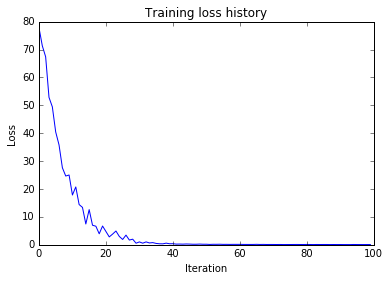

In [100]:
small_data = load_coco_data(max_train=50)
small_rnn_model = CaptioningRNN(
          cell_type='rnn',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
        )

small_rnn_solver = CaptioningSolver(small_rnn_model, small_data,
           update_rule='adam',
           num_epochs=50,
           batch_size=25,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=0.95,
           verbose=True, print_every=10,
         )

small_rnn_solver.train()

# Plot the training losses
plt.plot(small_rnn_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

# Test-time sampling
Unlike classification models, image captioning models behave very differently at training time and at test time. At training time, we have access to the ground-truth caption so we feed ground-truth words as input to the RNN at each timestep. At test time, we sample from the distribution over the vocabulary at each timestep, and feed the sample as input to the RNN at the next timestep.

In [101]:
def sample_coco_minibatch(data, batch_size=100, split='train'):
  split_size = data['%s_captions' % split].shape[0]
  mask = np.random.choice(split_size, batch_size)
  captions = data['%s_captions' % split][mask]
  image_idxs = data['%s_image_idxs' % split][mask]
  image_features = data['%s_features' % split][image_idxs]
  urls = data['%s_urls' % split][image_idxs]
  return captions, image_features, urls

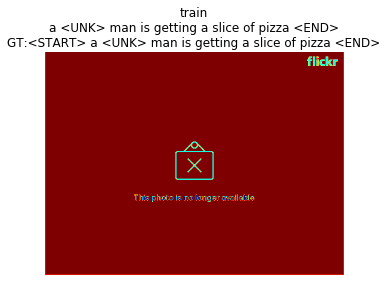

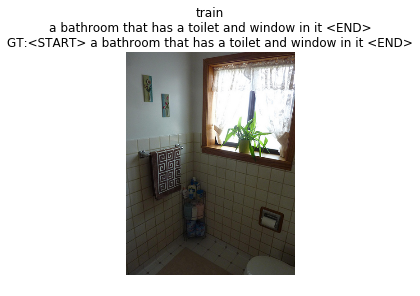

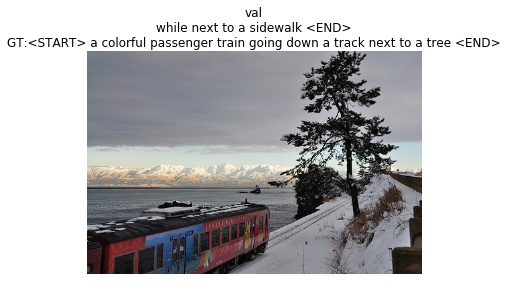

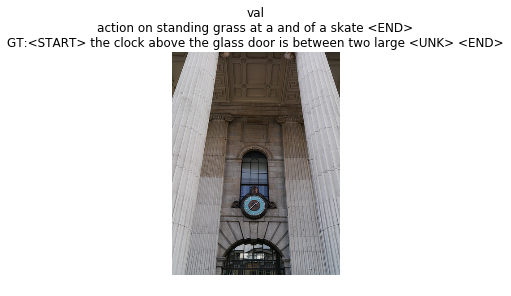

In [102]:
for split in ['train', 'val']:
  minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
  gt_captions, features, urls = minibatch
  gt_captions = decode_captions(gt_captions, data['idx_to_word'])

  sample_captions = small_rnn_model.sample(features)
  sample_captions = decode_captions(sample_captions, data['idx_to_word'])

  for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
    plt.imshow(image_from_url(url))
    plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
    plt.axis('off')
    plt.show()

# Image Captioning with LSTM's

# LSTM
Many people use a variant on the vanialla RNN called Long-Short Term Memory (LSTM) RNNs. Vanilla RNNs can be tough to train on long sequences due to vanishing and exploding gradiants caused by repeated matrix multiplication. LSTMs solve this problem by replacing the simple update rule of the vanilla RNN with a gating mechanism as follows.

Similar to the vanilla RNN, at each timestep we receive an input $x_t\in\mathbb{R}^D$ and the previous hidden state $h_{t-1}\in\mathbb{R}^H$; the LSTM also maintains an $H$-dimensional *cell state*, so we also receive the previous cell state $c_{t-1}\in\mathbb{R}^H$. The learnable parameters of the LSTM are an *input-to-hidden* matrix $W_x\in\mathbb{R}^{4H\times D}$, a *hidden-to-hidden* matrix $W_h\in\mathbb{R}^{4H\times H}$ and a *bias vector* $b\in\mathbb{R}^{4H}$.

At each timestep we first compute an *activation vector* $a\in\mathbb{R}^{4H}$ as $a=W_xx_t + W_hh_{t-1}+b$. We then divide this into four vectors $a_i,a_f,a_o,a_g\in\mathbb{R}^H$ where $a_i$ consists of the first $H$ elements of $a$, $a_f$ is the next $H$ elements of $a$, etc. We then compute the *input gate* $g\in\mathbb{R}^H$, *forget gate* $f\in\mathbb{R}^H$, *output gate* $o\in\mathbb{R}^H$ and *block input* $g\in\mathbb{R}^H$ as

$$
\begin{align*}
i = \sigma(a_i) \hspace{2pc}
f = \sigma(a_f) \hspace{2pc}
o = \sigma(a_o) \hspace{2pc}
g = \tanh(a_g)
\end{align*}
$$

where $\sigma$ is the sigmoid function and $\tanh$ is the hyperbolic tangent, both applied elementwise.

Finally we compute the next cell state $c_t$ and next hidden state $h_t$ as

$$
c_{t} = f\odot c_{t-1} + i\odot g \hspace{4pc}
h_t = o\odot\tanh(c_t)
$$

where $\odot$ is the elementwise product of vectors.

In the rest of the notebook we will implement the LSTM update rule and apply it to the image captioning task.

## LSTM: step forward


In [105]:
def sigmoid(x):
    """
    A numerically stable version of the logistic sigmoid function.
    """
    pos_mask = (x >= 0)
    neg_mask = (x < 0)
    z = np.zeros_like(x)
    z[pos_mask] = np.exp(-x[pos_mask])
    z[neg_mask] = np.exp(x[neg_mask])
    top = np.ones_like(x)
    top[neg_mask] = z[neg_mask]
    return top / (1 + z)


def lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b):
    """
    Forward pass for a single timestep of an LSTM.
    The input data has dimension D, the hidden state has dimension H, and we use
    a minibatch size of N.
    Inputs:
    - x: Input data, of shape (N, D)
    - prev_h: Previous hidden state, of shape (N, H)
    - prev_c: previous cell state, of shape (N, H)
    - Wx: Input-to-hidden weights, of shape (D, 4H)
    - Wh: Hidden-to-hidden weights, of shape (H, 4H)
    - b: Biases, of shape (4H,)
    Returns a tuple of:
    - next_h: Next hidden state, of shape (N, H)
    - next_c: Next cell state, of shape (N, H)
    - cache: Tuple of values needed for backward pass.
    """
    next_h, next_c, cache = None, None, None

    # Get the size
    H = prev_h.shape[1]

    # 1 First compute the intermediate vector
    a = np.dot(x, Wx) + np.dot(prev_h, Wh) + b

    # 2 Compute the gates
    ai = a[:, :H]
    af = a[:, H:2 * H]
    ao = a[:, 2 * H:3 * H]
    ag = a[:, 3 * H:4 * H]

    # 3 Compute the gate
    i = sigmoid(ai)
    f = sigmoid(af)
    o = sigmoid(ao)
    g = np.tanh(ag)

    # 4 Compute the next cell state
    next_c = f * prev_c + i * g

    # 5 Compute next hidden state
    next_h = o * np.tanh(next_c)

    # Get the cache for the backward pass
    cache = i, f, o, g, a, ai, af, ao, ag, Wx, Wh, b, prev_h, prev_c, x, next_c, next_h
    return next_h, next_c, cache


In [106]:
N, D, H = 3, 4, 5
x = np.linspace(-0.4, 1.2, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.3, 0.7, num=N*H).reshape(N, H)
prev_c = np.linspace(-0.4, 0.9, num=N*H).reshape(N, H)
Wx = np.linspace(-2.1, 1.3, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.7, 2.2, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.3, 0.7, num=4*H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

expected_next_h = np.asarray([
    [ 0.24635157,  0.28610883,  0.32240467,  0.35525807,  0.38474904],
    [ 0.49223563,  0.55611431,  0.61507696,  0.66844003,  0.7159181 ],
    [ 0.56735664,  0.66310127,  0.74419266,  0.80889665,  0.858299  ]])
expected_next_c = np.asarray([
    [ 0.32986176,  0.39145139,  0.451556,    0.51014116,  0.56717407],
    [ 0.66382255,  0.76674007,  0.87195994,  0.97902709,  1.08751345],
    [ 0.74192008,  0.90592151,  1.07717006,  1.25120233,  1.42395676]])

print('next_h error: ', rel_error(expected_next_h, next_h))
print('next_c error: ', rel_error(expected_next_c, next_c))

next_h error:  5.70541311858e-09
next_c error:  5.81431230888e-09


## LSTM : step backward

In [109]:

def lstm_step_backward(dnext_h, dnext_c, cache):
    """
    Backward pass for a single timestep of an LSTM.
    Inputs:
    - dnext_h: Gradients of next hidden state, of shape (N, H)
    - dnext_c: Gradients of next cell state, of shape (N, H)
    - cache: Values from the forward pass
    Returns a tuple of:
    - dx: Gradient of input data, of shape (N, D)
    - dprev_h: Gradient of previous hidden state, of shape (N, H)
    - dprev_c: Gradient of previous cell state, of shape (N, H)
    - dWx: Gradient of input-to-hidden weights, of shape (D, 4H)
    - dWh: Gradient of hidden-to-hidden weights, of shape (H, 4H)
    - db: Gradient of biases, of shape (4H,)
    """
    dx, dh, dc, dWx, dWh, db = None, None, None, None, None, None

    # Backward pass

    # unroll cache
    i, f, o, g, a, ai, af, ao, ag, Wx, Wh, b, prev_h, prev_c, x, next_c, next_h = cache

    # Backprop into step 5

    do = np.tanh(next_c) * dnext_h
    dnext_c += o * (1 - np.tanh(next_c)**2) * dnext_h

    # Backprop into step 4
    df = prev_c * dnext_c
    dprev_c = f * dnext_c
    di = g * dnext_c
    dg = i * dnext_c

    # Backprop into the gate 3
    dag = (1 - np.tanh(ag)**2) * dg
    dao = sigmoid(ao) * (1 - sigmoid(ao)) * do
    daf = sigmoid(af) * (1 - sigmoid(af)) * df
    dai = sigmoid(ai) * (1 - sigmoid(ai)) * di

    # Backprop into 2
    da = np.hstack((dai, daf, dao, dag))

    # Backprop into 1
    dx = np.dot(da, Wx.T)
    dWx = np.dot(x.T, da)
    dprev_h = np.dot(da, Wh.T)
    dWh = np.dot(prev_h.T, da)
    db = np.sum(da, axis=0)

    return dx, dprev_h, dprev_c, dWx, dWh, db

In [110]:
N, D, H = 4, 5, 6
x = np.random.randn(N, D)
prev_h = np.random.randn(N, H)
prev_c = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

dnext_h = np.random.randn(*next_h.shape)
dnext_c = np.random.randn(*next_c.shape)

fx_h = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fh_h = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fc_h = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWx_h = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWh_h = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fb_h = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]

fx_c = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fh_c = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fc_c = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWx_c = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWh_c = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fb_c = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]

num_grad = eval_numerical_gradient_array

dx_num = num_grad(fx_h, x, dnext_h) + num_grad(fx_c, x, dnext_c)
dh_num = num_grad(fh_h, prev_h, dnext_h) + num_grad(fh_c, prev_h, dnext_c)
dc_num = num_grad(fc_h, prev_c, dnext_h) + num_grad(fc_c, prev_c, dnext_c)
dWx_num = num_grad(fWx_h, Wx, dnext_h) + num_grad(fWx_c, Wx, dnext_c)
dWh_num = num_grad(fWh_h, Wh, dnext_h) + num_grad(fWh_c, Wh, dnext_c)
db_num = num_grad(fb_h, b, dnext_h) + num_grad(fb_c, b, dnext_c)

dx, dh, dc, dWx, dWh, db = lstm_step_backward(dnext_h, dnext_c, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dh error: ', rel_error(dh_num, dh))
print('dc error: ', rel_error(dc_num, dc))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  1.34807003169e-09
dh error:  1.94356542243e-10
dc error:  1.40719117851e-10
dWx error:  1.75976186499e-08
dWh error:  1.04291139757e-08
db error:  7.19163024599e-10


# LSTM: forward


In [113]:
def lstm_forward(x, h0, Wx, Wh, b):
    """
    Forward pass for an LSTM over an entire sequence of data. We assume an input
    sequence composed of T vectors, each of dimension D. The LSTM uses a hidden
    size of H, and we work over a minibatch containing N sequences. After running
    the LSTM forward, we return the hidden states for all timesteps.
    Note that the initial cell state is passed as input, but the initial cell
    state is set to zero. Also note that the cell state is not returned; it is
    an internal variable to the LSTM and is not accessed from outside.
    Inputs:
    - x: Input data of shape (N, T, D)
    - h0: Initial hidden state of shape (N, H)
    - Wx: Weights for input-to-hidden connections, of shape (D, 4H)
    - Wh: Weights for hidden-to-hidden connections, of shape (H, 4H)
    - b: Biases of shape (4H,)
    Returns a tuple of:
    - h: Hidden states for all timesteps of all sequences, of shape (N, T, H)
    - cache: Values needed for the backward pass.
    """
    h, cache = None, None
   

    N, T, D = x.shape
    N, H = h0.shape

    # some initialization
    prev_h = h0
    prev_c = np.zeros_like(prev_h)
    h = np.zeros((T, N, H))
    x = x.transpose(1, 0, 2)
    cache = []

    # run the loop on times
    for t in range(T):
        if t > 0:
            prev_h = h[t - 1]
            prev_c = next_c
        h[t], next_c, cache_next = lstm_step_forward(
            x[t], prev_h, prev_c, Wx, Wh, b)
        cache.append(cache_next)
    h = h.transpose(1, 0, 2)

    return h, cache



In [114]:
N, D, H, T = 2, 5, 4, 3
x = np.linspace(-0.4, 0.6, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.4, 0.8, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.9, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.3, 0.6, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.2, 0.7, num=4*H)

h, cache = lstm_forward(x, h0, Wx, Wh, b)

expected_h = np.asarray([
 [[ 0.01764008,  0.01823233,  0.01882671,  0.0194232 ],
  [ 0.11287491,  0.12146228,  0.13018446,  0.13902939],
  [ 0.31358768,  0.33338627,  0.35304453,  0.37250975]],
 [[ 0.45767879,  0.4761092,   0.4936887,   0.51041945],
  [ 0.6704845,   0.69350089,  0.71486014,  0.7346449 ],
  [ 0.81733511,  0.83677871,  0.85403753,  0.86935314]]])

print('h error: ', rel_error(expected_h, h))

h error:  8.61053745211e-08


# LSTM: backward


In [118]:
def lstm_backward(dh, cache):
    """
    Backward pass for an LSTM over an entire sequence of data.]
    Inputs:
    - dh: Upstream gradients of hidden states, of shape (N, T, H)
    - cache: Values from the forward pass
    Returns a tuple of:
    - dx: Gradient of input data of shape (N, T, D)
    - dh0: Gradient of initial hidden state of shape (N, H)
    - dWx: Gradient of input-to-hidden weight matrix of shape (D, 4H)
    - dWh: Gradient of hidden-to-hidden weight matrix of shape (H, 4H)
    - db: Gradient of biases, of shape (4H,)
    """
    dx, dh0, dWx, dWh, db = None, None, None, None, None

    # Backprop into the lstm.

    # Dimensions
    N, T, H = dh.shape
    i, f, o, g, a, ai, af, ao, ag, Wx, Wh, b, prev_h, prev_c, x, next_c, next_h = cache[
        0]
    D = x.shape[-1]

    # Initialize dx,dh0,dWx,dWh,db
    dx = np.zeros((T, N, D))
    dh0 = np.zeros((N, H))
    db = np.zeros((4 * H,))
    dWh = np.zeros((H, 4 * H))
    dWx = np.zeros((D, 4 * H))

    # On transpose dh
    dh = dh.transpose(1, 0, 2)
    dh_prev = np.zeros((N, H))
    dc_prev = np.zeros_like(dh_prev)

    for t in reversed(range(T)):
        dh_current = dh[t] + dh_prev
        dc_current = dc_prev
        dx_t, dh_prev, dc_prev, dWx_t, dWh_t, db_t = lstm_step_backward(
            dh_current, dc_current, cache[t])
        dx[t] += dx_t
        dh0 = dh_prev
        dWx += dWx_t
        dWh += dWh_t
        db += db_t

    dx = dx.transpose(1, 0, 2)
    return dx, dh0, dWx, dWh, db

In [119]:
N, D, T, H = 2, 3, 10, 6

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

out, cache = lstm_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = lstm_backward(dout, cache)

fx = lambda x: lstm_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: lstm_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: lstm_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: lstm_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: lstm_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dx_num, dx))
print('dWx error: ', rel_error(dx_num, dx))
print('dWh error: ', rel_error(dx_num, dx))
print('db error: ', rel_error(dx_num, dx))

dx error:  2.76773702383e-09
dh0 error:  2.76773702383e-09
dWx error:  2.76773702383e-09
dWh error:  2.76773702383e-09
db error:  2.76773702383e-09


In [120]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='lstm',
          dtype=np.float64)

# Set all model parameters to fixed values
for k, v in model.params.items():
  model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-0.5, 1.7, num=N*D).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.82445935443

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

loss:  9.82445935443
expected loss:  9.82445935443
difference:  2.26485497024e-12


(Iteration 1 / 100) loss: 75.487988
(Iteration 11 / 100) loss: 38.570352
(Iteration 21 / 100) loss: 21.920101
(Iteration 31 / 100) loss: 12.333898
(Iteration 41 / 100) loss: 5.626549
(Iteration 51 / 100) loss: 1.673908
(Iteration 61 / 100) loss: 0.634552
(Iteration 71 / 100) loss: 0.270554
(Iteration 81 / 100) loss: 0.143679
(Iteration 91 / 100) loss: 0.096355


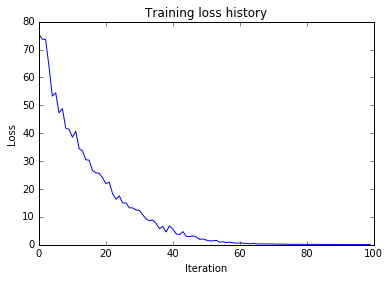

In [121]:
small_data = load_coco_data(max_train=50)

small_lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

small_lstm_solver = CaptioningSolver(small_lstm_model, small_data,
           update_rule='adam',
           num_epochs=50,
           batch_size=25,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=10,
         )

small_lstm_solver.train()

# Plot the training losses
plt.plot(small_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

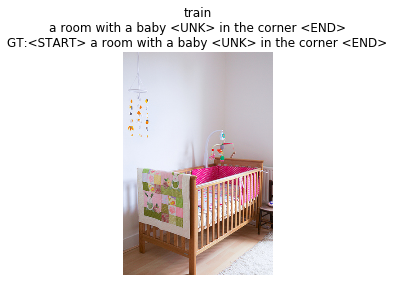

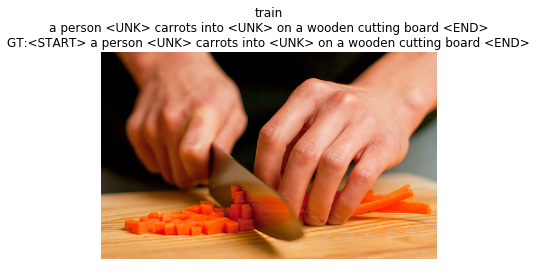

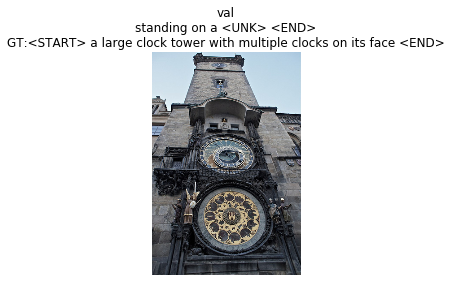

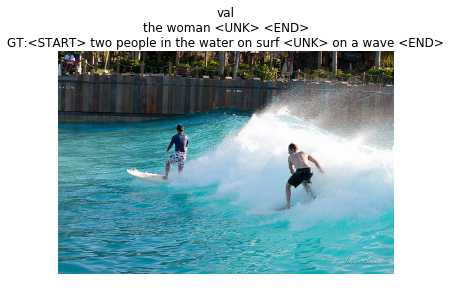

In [122]:
for split in ['train', 'val']:
  minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
  gt_captions, features, urls = minibatch
  gt_captions = decode_captions(gt_captions, data['idx_to_word'])

  sample_captions = small_lstm_model.sample(features)
  sample_captions = decode_captions(sample_captions, data['idx_to_word'])

  for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
    plt.imshow(image_from_url(url))
    plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
    plt.axis('off')
    plt.show()